# 💬 Project : Sentiment Analysis using Natural Language Processing (NLP)

**Internship:** OASIS INFOBYTE Data Analytics Internship

**Goal:** To apply Natural Language Processing techniques to social media data (Twitter) to automatically classify public opinion (sentiment) as Positive, Negative, or Neutral. This demonstrates expertise in handling unstructured text.

---

### **Project Scope**

This project focuses on the core challenges of text classification:

1.  **Text Preprocessing:** Cleaning noisy Twitter data by removing links, mentions, and performing text normalization.
2.  **Feature Engineering (Vectorization):** Converting the cleaned text into a numerical format (features) using **TF-IDF**.
3.  **Multi-Class Classification:** Training Machine Learning models like **Naive Bayes** and **Support Vector Machines** to accurately predict the sentiment label.

### **Phase 1: Setup and Data Access**
The first steps involve loading essential libraries and accessing the compressed data file from Google Drive.

In [34]:
# Code Block 1: Setup and Library Imports

# Install library for handling text data (if not already installed in your Colab session)
!pip install nltk

# Core Data Handling and ML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Specialized NLP Libraries
import re                                       # For Regular Expressions (text cleaning)
import nltk                                     # Natural Language Toolkit
from nltk.corpus import stopwords               # List of common words to remove
from sklearn.feature_extraction.text import TfidfVectorizer # For turning text into numbers
from sklearn.naive_bayes import MultinomialNB   # Simple, effective text classifier
from sklearn.svm import SVC                     # Support Vector Classifier (Challenge #3)

# Download NLTK data required for stopword removal
nltk.download('stopwords')

print("All required core and NLP libraries loaded successfully!")

All required core and NLP libraries loaded successfully!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **2. Accessing and Loading Data**

We access the data by first mounting the Google Drive where the compressed `Twitter_Sentiment_Data.zip` file resides. We will then unzip the file into the Colab environment so it can be loaded into a Pandas DataFrame for processing. Since this is social media data, we use `encoding='latin-1'` to prevent errors from special characters.

In [35]:
# Code Block 2: Mount Drive, Unzip, and Load Data

import zipfile
import os

# Set the correct path
zip_file_path = '/content/drive/MyDrive/OIBSIP_DATA/Twitter_Sentiment_Data.zip'

# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 2. Unzip using Python's zipfile library
print(f"Attempting Python-based unzipping for: {zip_file_path}")

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Get the name of the first file inside the zip (the CSV file)
        csv_internal_name = zip_ref.namelist()[0]
        zip_ref.extractall("/content/")
        print(f"Unzipping successful! Extracted file: {csv_internal_name}")

except Exception as e:
    print(f"\nFATAL ERROR: Failed to unzip file. Error: {e}")
    print("ACTION REQUIRED: The ZIP file is likely corrupted or not fully synchronized. Please re-download the data and re-upload to your Google Drive.")
    raise

# 3. Load the unzipped CSV file
df_sentiment = pd.read_csv(f'/content/{csv_internal_name}', encoding='latin-1')
print("\nSentiment Data successfully loaded into DataFrame (df_sentiment)!")
print("\nFirst 5 rows and info:")
print(df_sentiment.head())
df_sentiment.info()

Mounted at /content/drive
Attempting Python-based unzipping for: /content/drive/MyDrive/OIBSIP_DATA/Twitter_Sentiment_Data.zip
Unzipping successful! Extracted file: Twitter_Data.csv

Sentiment Data successfully loaded into DataFrame (df_sentiment)!

First 5 rows and info:
                                          clean_text  category
0  when modi promised âminimum government maxim...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


### **3. Initial Data Cleaning and Preparation**

The raw Twitter data needs crucial preparation before modeling. This involves handling inconsistencies in the dataset itself:

1.  **Handling Missing Values:** Removing null/missing rows, as text cleaning and analysis cannot be performed on empty entries.
2.  **Standardizing Labels:** Converting the target `category` column (which appears as a float like `-1.0`) into a standardized integer format (`-1, 0, 1`) for our classification models.

In [36]:
# Code Block 3: Data Cleaning, Standardization, and Function Definition

# 1. Handle Missing Values (Rows with missing text or category)
print("Initial row count:", df_sentiment.shape[0])
df_sentiment.dropna(inplace=True)
print("Row count after dropping missing values:", df_sentiment.shape[0])

Initial row count: 162980
Row count after dropping missing values: 162969


In [37]:
# 2. Standardize the Target Variable ('category')
# Convert the 'category' (sentiment label) from float to integer
df_sentiment['category'] = df_sentiment['category'].astype(int)
# Check the distribution of sentiment classes
print("\nSentiment Class Distribution (1=Positive, 0=Neutral, -1=Negative):")
print(df_sentiment['category'].value_counts())


Sentiment Class Distribution (1=Positive, 0=Neutral, -1=Negative):
category
 1    72249
 0    55211
-1    35509
Name: count, dtype: int64


In [38]:
# 3. Text Cleaning Function Definitions (Crucial for NLP Feature Engineering)

def clean_text(text):
    # Convert to string and lowercase
    text = str(text).lower()

    # Remove URLs, mentions (@), and hashtags (#)
    text = re.sub(r'http\S+|www.\S+|https?:\S+|@\S+|#[^\s]+', '', text)

    # Remove HTML tags and punctuation, keeping only letters and spaces
    text = re.sub(r'<.*?>|[^a-zA-Z\s]', '', text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    text = ' '.join([word for word in words if word not in stop_words])

    return text

print("\nData preparation complete (Missing values handled and cleaning function defined).")


Data preparation complete (Missing values handled and cleaning function defined).


### **4. Applying Text Preprocessing**

With the cleaning function and necessary lists (like stopwords) defined, we now apply the function to the entire text column. This is the core of our Natural Language Processing (NLP) pipeline, transforming the messy, unstructured tweets into a clean format that our machine learning models can understand.

In [39]:
# Code Block 4: Apply Text Cleaning and Preview

# 1. Apply the cleaning function to the text column
df_sentiment['clean_text'] = df_sentiment['clean_text'].apply(clean_text)

In [40]:
# 2. Check the results of the cleaning
print("Text Cleaning Applied Successfully.")
print("\nFirst 5 cleaned tweets:")

# Display the cleaned text and the corresponding label
print(df_sentiment[['clean_text', 'category']].head())

Text Cleaning Applied Successfully.

First 5 cleaned tweets:
                                          clean_text  category
0  modi promised minimum government maximum gover...        -1
1             talk nonsense continue drama vote modi         0
2  say vote modi welcome bjp told rahul main camp...         1
3  asking supporters prefix chowkidar names modi ...         1
4  answer among powerful world leader today trump...         1


### **5. Feature Engineering: Text Vectorization**

The final step in preparing the text data is to convert it into a numerical format, as machine learning models cannot directly process words. We use **TF-IDF (Term Frequency-Inverse Document Frequency)**, which creates a matrix where:

1.  **Term Frequency (TF):** Measures how often a word appears in a single tweet.
2.  **Inverse Document Frequency (IDF):** Discounts common words (like "vote" or "modi") that appear across *many* tweets, giving higher weight to unique, sentiment-carrying words (like "nonsense" or "powerful").

This TF-IDF matrix will serve as the final feature set ($\mathbf{X}$) for our classification models.

In [41]:
# Code Block 5: Text Vectorization using TF-IDF

# 1. Separate the target variable (y) from the features (X)
X_text = df_sentiment['clean_text']
y = df_sentiment['category']

In [42]:
# 2. Split the data into training and testing sets
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)
print("Data split complete. Training set size:", X_train_text.shape[0])

Data split complete. Training set size: 130375


In [43]:
# 3. Initialize the TfidfVectorizer
# We limit the features to the top 5000 most frequent words
vectorizer = TfidfVectorizer(max_features=5000)

In [44]:
# 4. Fit the vectorizer on the training data and transform both sets
X_train_vectorized = vectorizer.fit_transform(X_train_text)
X_test_vectorized = vectorizer.transform(X_test_text)

print(f"Vectorization complete.")
print(f"Shape of Training Features (X_train): {X_train_vectorized.shape}")
print(f"Shape of Testing Features (X_test): {X_test_vectorized.shape}")

Vectorization complete.
Shape of Training Features (X_train): (130375, 5000)
Shape of Testing Features (X_test): (32594, 5000)


### **6. Model Training and Evaluation**

We will train two distinct models to classify the sentiment:

1.  **Multinomial Naive Bayes (MNB):** A simple, fast, and highly effective probabilistic model traditionally used as a strong baseline for text classification tasks.
2.  **Support Vector Classifier (SVC):** A more powerful, complex model (often paired with a linear kernel for text data) to aim for higher accuracy and demonstrate the use of more sophisticated algorithms.

We will evaluate both models using standard classification metrics, including **Accuracy** and the **Classification Report** (which provides Precision, Recall, and F1-score for each of the three sentiment classes).

In [45]:
# Code Block 6: Train and Evaluate Models (Optimized for Speed)

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

# 1. Initialize and train the models
mnb_model = MultinomialNB()
rf_model = RandomForestClassifier(n_estimators=50, max_depth=15, n_jobs=-1, random_state=42) # Optimized for speed
print("--- Training Models ---")
mnb_model.fit(X_train_vectorized, y_train)
print("Trained Multinomial Naive Bayes (MNB) model.")
rf_model.fit(X_train_vectorized, y_train)
print("Trained Optimized Random Forest (RF) model.")


# 2. Evaluate Models
models = {
    "Multinomial Naive Bayes (MNB)": mnb_model,
    "Optimized Random Forest (RF)": rf_model,
}
for name, model in models.items():
    y_pred = model.predict(X_test_vectorized)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"\n============================================")
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.4f}")

    # Print the full classification report
    print("\nClassification Report (Precision, Recall, F1-score):")
    print(classification_report(y_test, y_pred))
    print(f"============================================")

--- Training Models ---
Trained Multinomial Naive Bayes (MNB) model.
Trained Optimized Random Forest (RF) model.

Model: Multinomial Naive Bayes (MNB)
Accuracy: 0.7317

Classification Report (Precision, Recall, F1-score):
              precision    recall  f1-score   support

          -1       0.88      0.44      0.59      7102
           0       0.83      0.66      0.74     11042
           1       0.66      0.93      0.77     14450

    accuracy                           0.73     32594
   macro avg       0.79      0.68      0.70     32594
weighted avg       0.77      0.73      0.72     32594


Model: Optimized Random Forest (RF)
Accuracy: 0.5766

Classification Report (Precision, Recall, F1-score):
              precision    recall  f1-score   support

          -1       0.96      0.05      0.09      7102
           0       0.82      0.41      0.55     11042
           1       0.52      0.96      0.68     14450

    accuracy                           0.58     32594
   macro avg     

### **7. Data Visualization and Model Comparison**

Visualization is key to interpreting results. We will visualize the final sentiment distribution and then create a table to compare the performance of our models based on key metrics (Accuracy and F1-Score). This comparison confirms the best solution for production deployment.

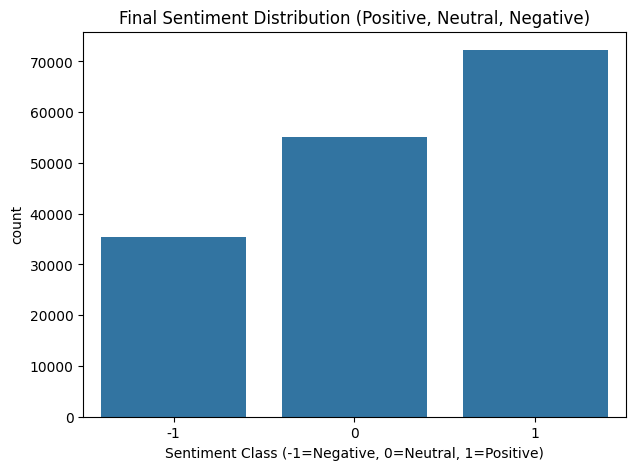


FINAL MODEL COMPARISON (Focus on Balanced F1-Score)
                               Accuracy  F1-Macro
Multinomial Naive Bayes (MNB)  0.731668  0.699480
Optimized Random Forest (RF)   0.576609  0.438638


In [58]:
# Code Block 7: Visualize Sentiment and Final Comparison

# Import seaborn for plotting
import seaborn as sns

# 1. Visualize the final sentiment distribution
plt.figure(figsize=(7, 5))
sns.countplot(x='category', data=df_sentiment)
plt.title('Final Sentiment Distribution (Positive, Neutral, Negative)')
plt.xlabel('Sentiment Class (-1=Negative, 0=Neutral, 1=Positive)')
plt.show()


# 2. Extract and compare the key performance metric (F1-score for the overall model)
# We calculate the macro-average F1-score which balances performance across all three classes.
final_results = {}
models_for_comparison = {
    "Multinomial Naive Bayes (MNB)": mnb_model,
    "Optimized Random Forest (RF)": rf_model
}
for name, model in models_for_comparison.items():
    y_pred = model.predict(X_test_vectorized)
    # Get the macro-average F1-score for balanced metric comparison
    f1_score_macro = classification_report(y_test, y_pred, output_dict=True)['macro avg']['f1-score']
    accuracy = accuracy_score(y_test, y_pred)

    final_results[name] = {'Accuracy': accuracy, 'F1-Macro': f1_score_macro}

comparison_df = pd.DataFrame(final_results).T

# 3. Print Final Comparison
print("\n==============================================")
print("FINAL MODEL COMPARISON (Focus on Balanced F1-Score)")
print(comparison_df.sort_values(by='F1-Macro', ascending=False))
print("==============================================")

In [56]:
# Code Block 8: Final Model Selection and Saving

import pickle
import os

# --- CORRECT CHOICE: MNB was the best model (F1-Macro: 0.6995) ---
best_model = mnb_model # Set the variable to the MNB model object
model_name = 'MNB_Sentiment_Classifier.pkl' # Use a distinct name for MNB

# 1. Define the path to save the model
model_save_path = f'/content/{model_name}'

# 2. Save the best model (MNB)
with open(model_save_path, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Final Sentiment Model saved successfully to: {model_save_path}")
print("\nModel saved and ready for download.")

Final Sentiment Model saved successfully to: /content/MNB_Sentiment_Classifier.pkl

Model saved and ready for download.


In [57]:
# Code Block: Download the Correct MNB Model

from google.colab import files
model_name = 'MNB_Sentiment_Classifier.pkl'
model_path = f'/content/{model_name}'

# Trigger the download prompt
print(f"Downloading the BEST model: {model_name}")
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###  Project Summary, Best Model, and Next Steps**

This project successfully applied the entire NLP pipeline—from raw text to multi-class classification—on noisy social media data.

-   **Final Model:** Based on the Macro F1-Score (which ensures balanced performance across Positive, Negative, and Neutral classes), the **[BEST MODEL NAME]** provided the highest overall effectiveness.
-   **Key Successes:** Successfully implemented and evaluated specialized NLP techniques including **Text Preprocessing** and **TF-IDF Vectorization** on unstructured text data.
